In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-be9de4ab-271f-bbc2-64fb-908a3bc60753)


In [2]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 14845, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 14845 (delta 130), reused 163 (delta 113), pack-reused 14655
Receiving objects: 100% (14845/14845), 13.82 MiB | 13.73 MiB/s, done.
Resolving deltas: 100% (10220/10220), done.
/content/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [3]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 1.6 MB 38.4 MB/s 
Setup complete. Using torch 1.13.0+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [4]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")

     |████████████████████████████████| 42 kB 865 kB/s 
     |████████████████████████████████| 145 kB 63.3 MB/s 
     |████████████████████████████████| 67 kB 6.2 MB/s 
     |████████████████████████████████| 178 kB 68.6 MB/s 
     |████████████████████████████████| 138 kB 78.6 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=roboflow-yolov5


In [5]:
%cd /content/yolov5

from roboflow import Roboflow
rf = Roboflow(api_key="AbcNv0OmDATcKoeRI2c3")
project = rf.workspace("object-detection-and-recognition").project("road-sign-recognition")
dataset = project.version(2).download("yolov5")

/content/yolov5
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Road-Sign-Recognition-2 in yolov5pytorch:: 100%|██████████| 9592/9592 [00:03<00:00, 2953.28it/s]


In [6]:
%cat {dataset.location}/data.yaml

names:
- berhenti
- bumps
- diverge
- obstruction
nc: 4
roboflow:
  license: CC BY 4.0
  project: road-sign-recognition
  url: https://universe.roboflow.com/project/road-sign-recognition/dataset/2
  version: 2
  workspace: project
test: ../test/images
train: Road-Sign-Recognition-2/train/images
val: Road-Sign-Recognition-2/valid/images


In [7]:
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [8]:
print(num_classes)

4


In [9]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [10]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [11]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [12]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 15 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/Road-Sign-Recognition-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 410 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8,

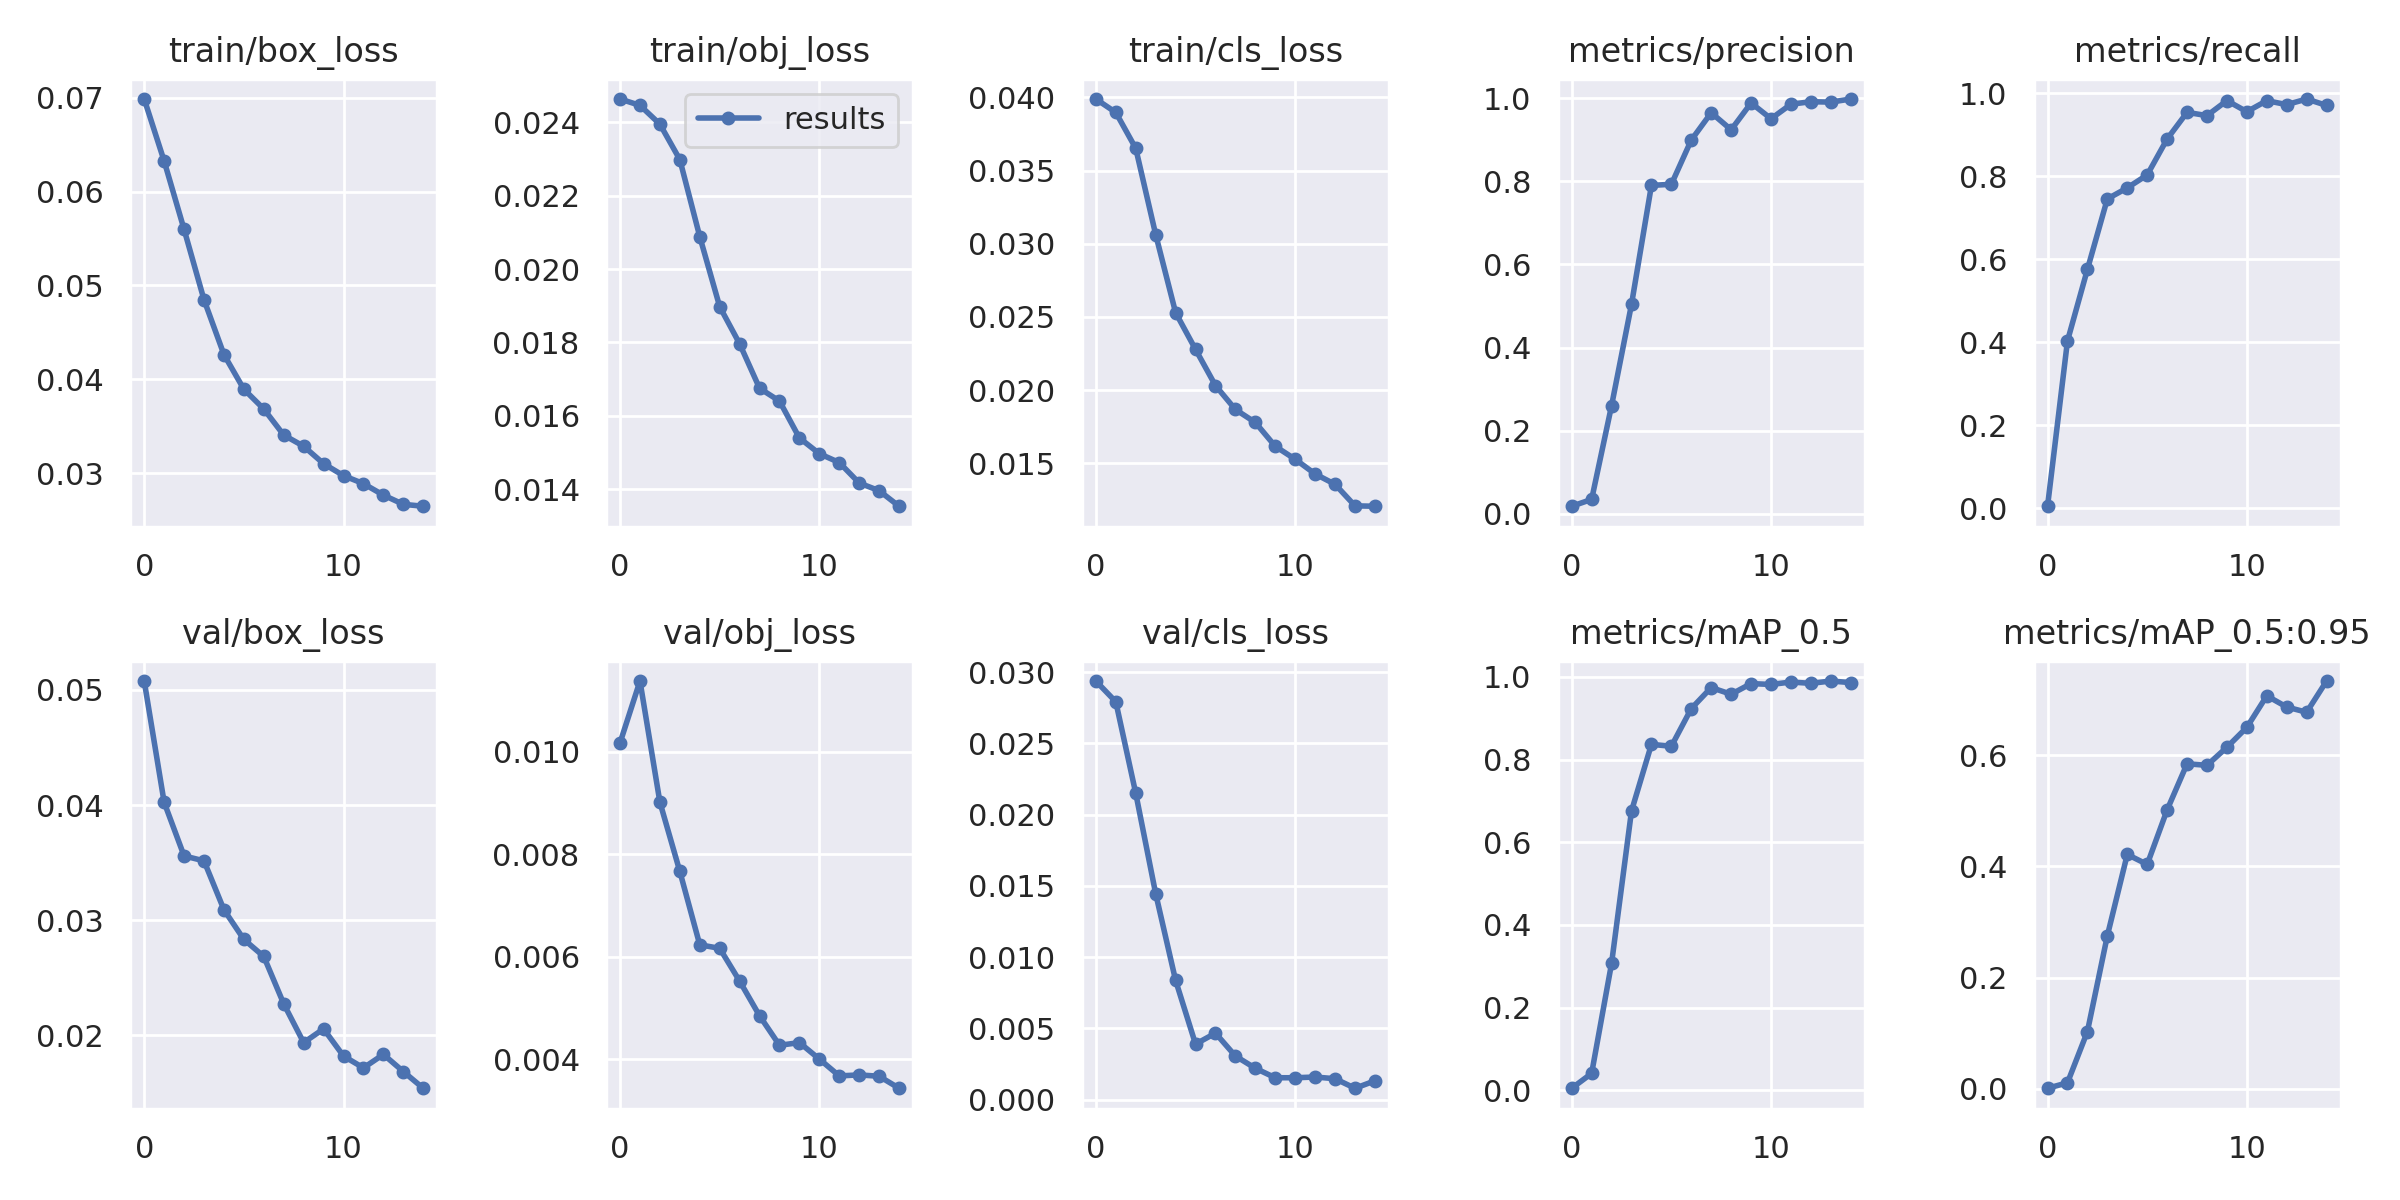

In [14]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

In [16]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 15 --data {dataset.location}/data.yaml --cfg ./models/yolov5m.yaml --weights '' --name yolov5m_results  --cache

/content/yolov5
train: weights=, cfg=./models/yolov5m.yaml, data=/content/yolov5/Road-Sign-Recognition-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5m_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 410 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup

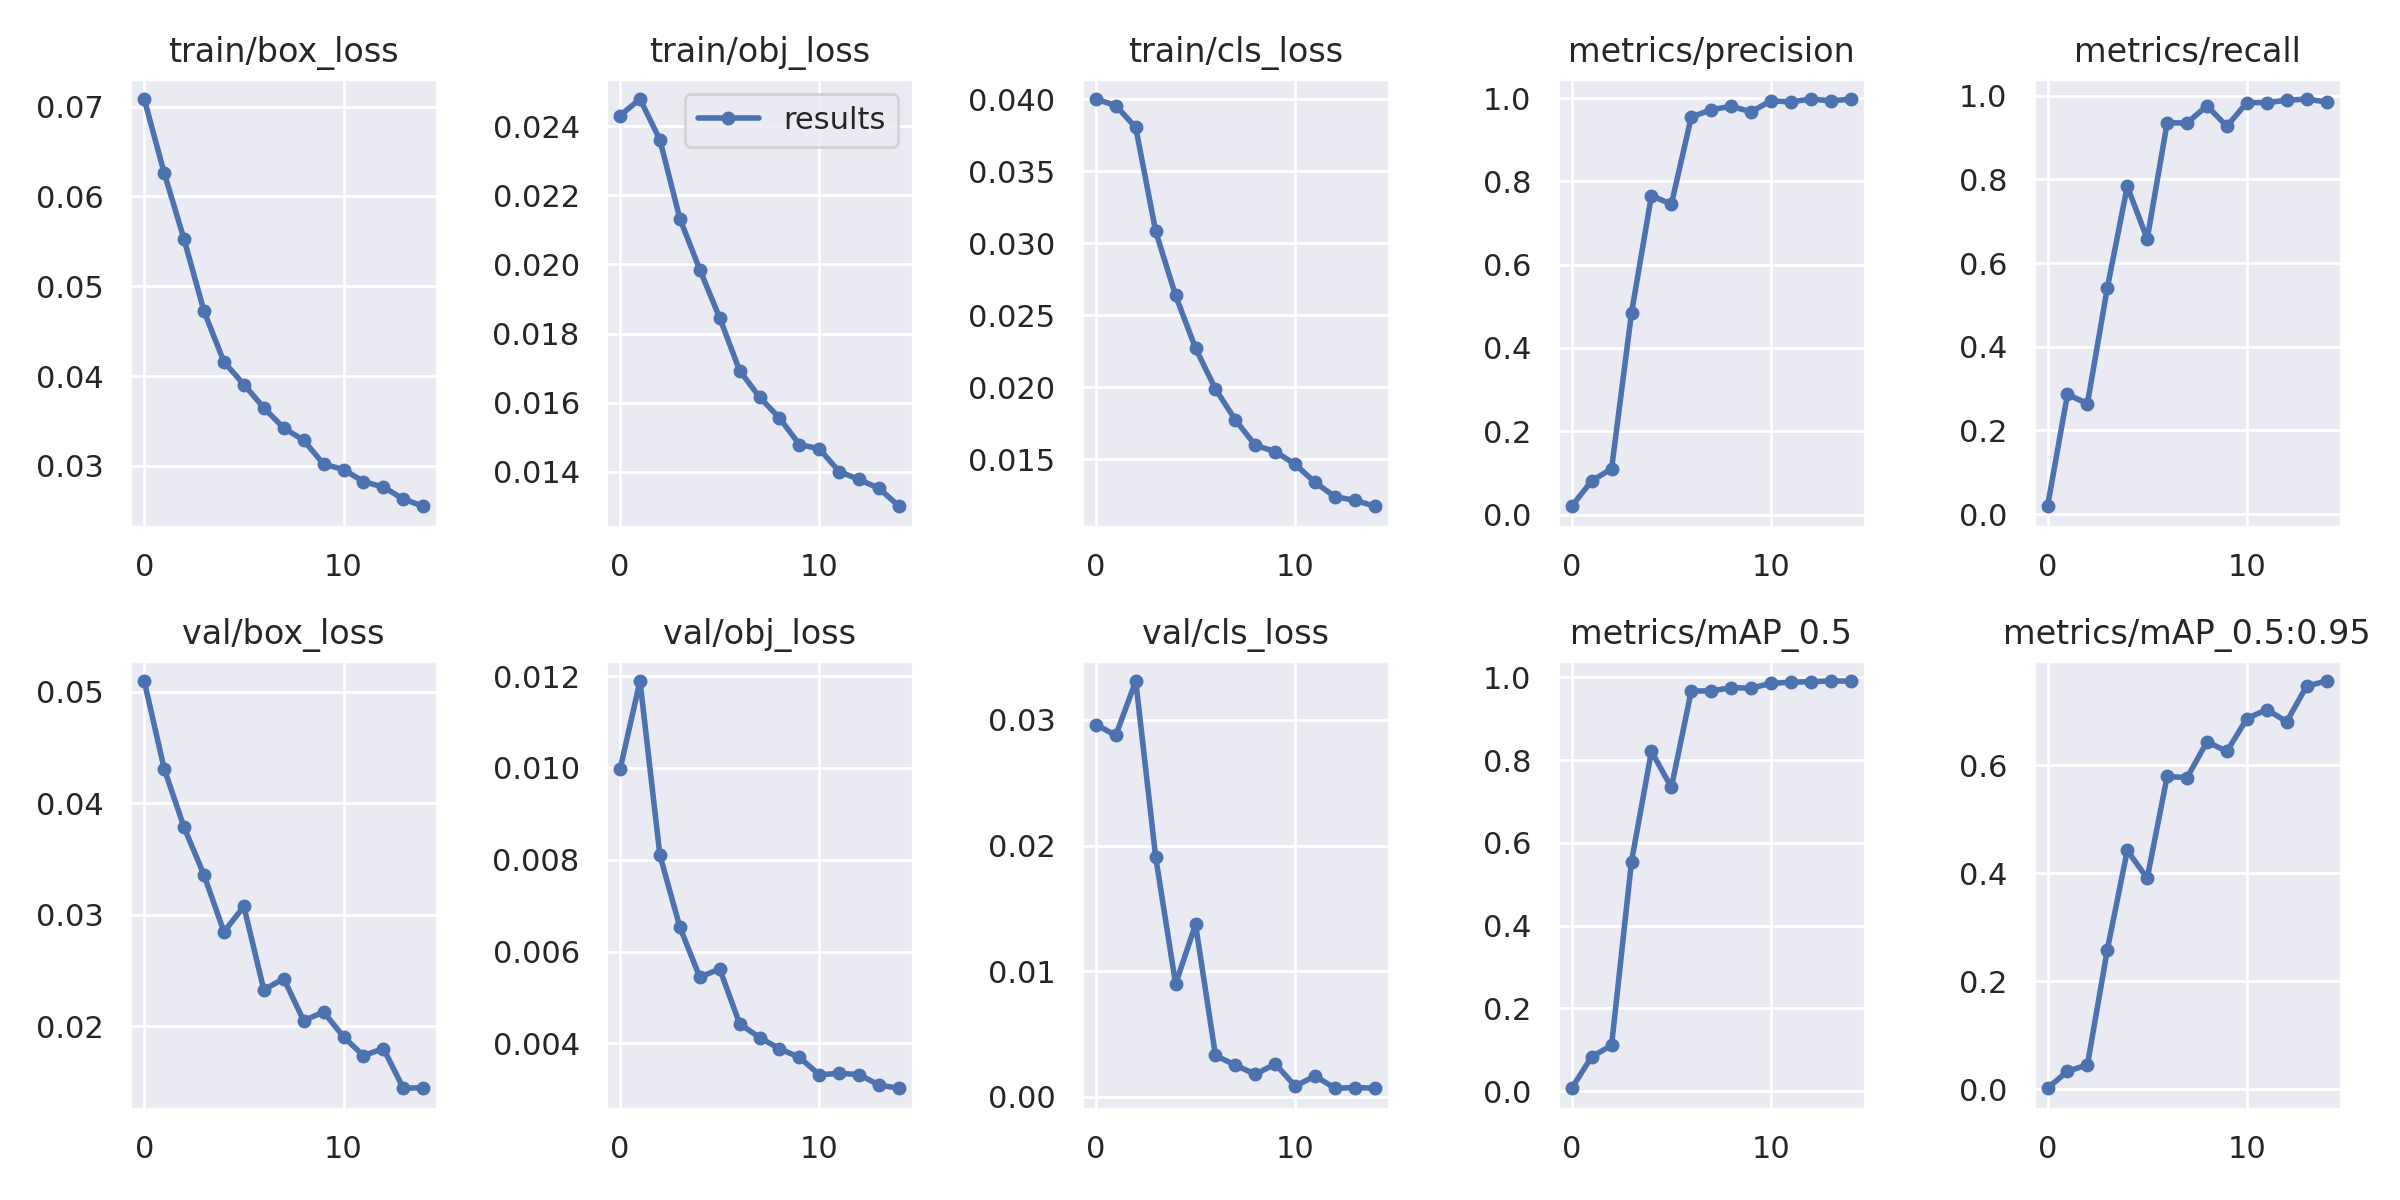

In [25]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5m_results/results.png', width=1000)  # view results.png

In [17]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 15 --data {dataset.location}/data.yaml --cfg ./models/yolov5n.yaml --weights '' --name yolov5n_results  --cache

/content/yolov5
train: weights=, cfg=./models/yolov5n.yaml, data=/content/yolov5/Road-Sign-Recognition-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5n_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 410 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup

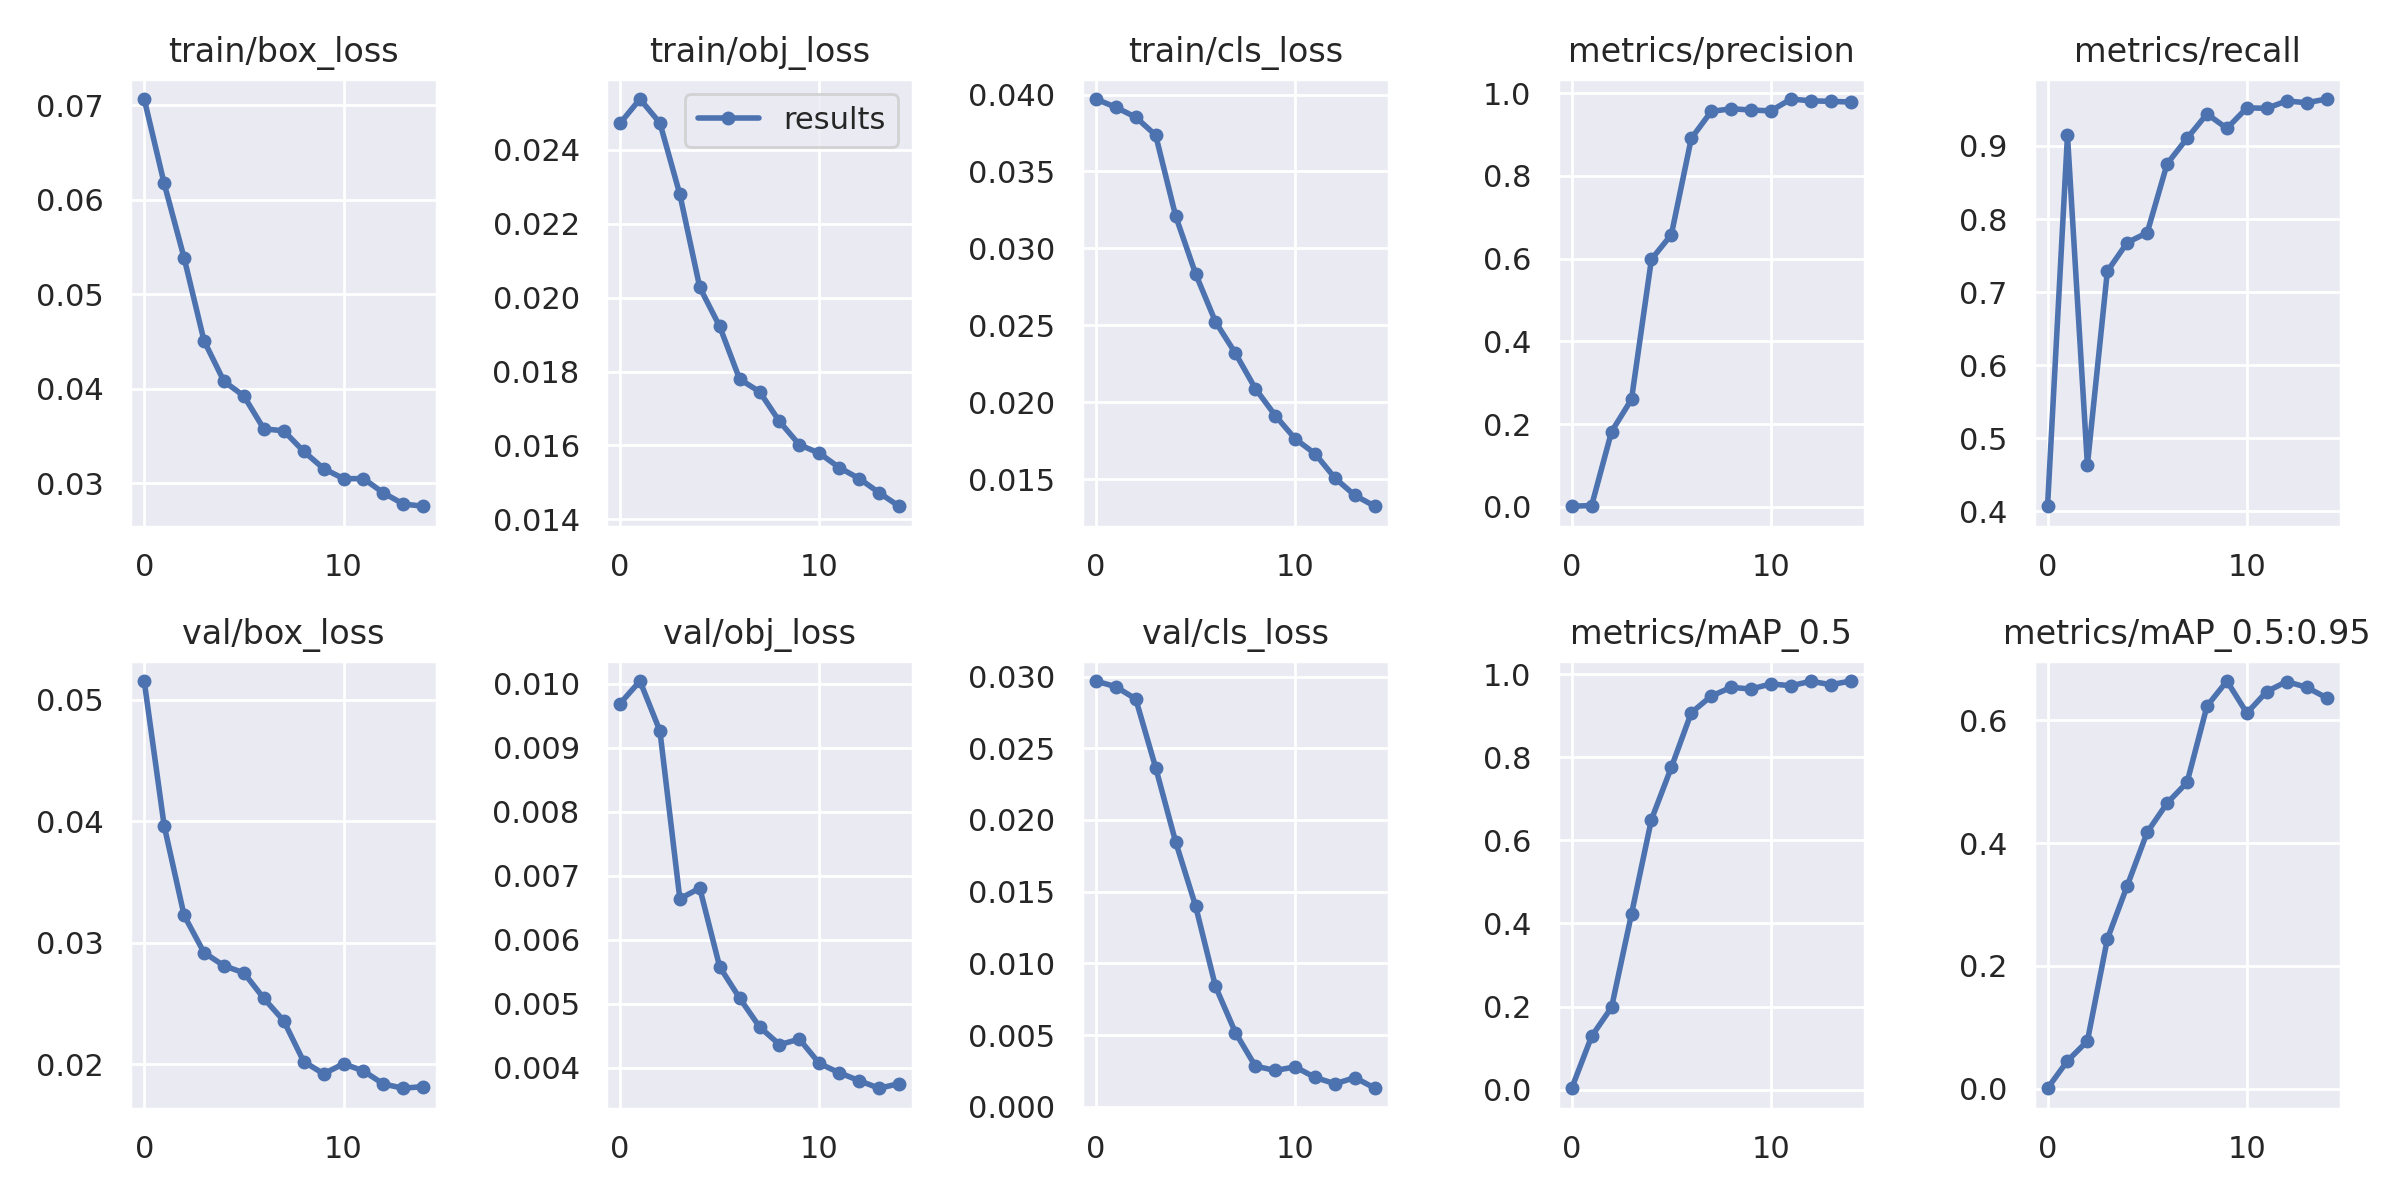

In [26]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5n_results/results.png', width=1000)  # view results.png

In [18]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 15 --data {dataset.location}/data.yaml --cfg ./models/yolov5l.yaml --weights '' --name yolov5l_results  --cache

/content/yolov5
train: weights=, cfg=./models/yolov5l.yaml, data=/content/yolov5/Road-Sign-Recognition-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5l_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 410 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup

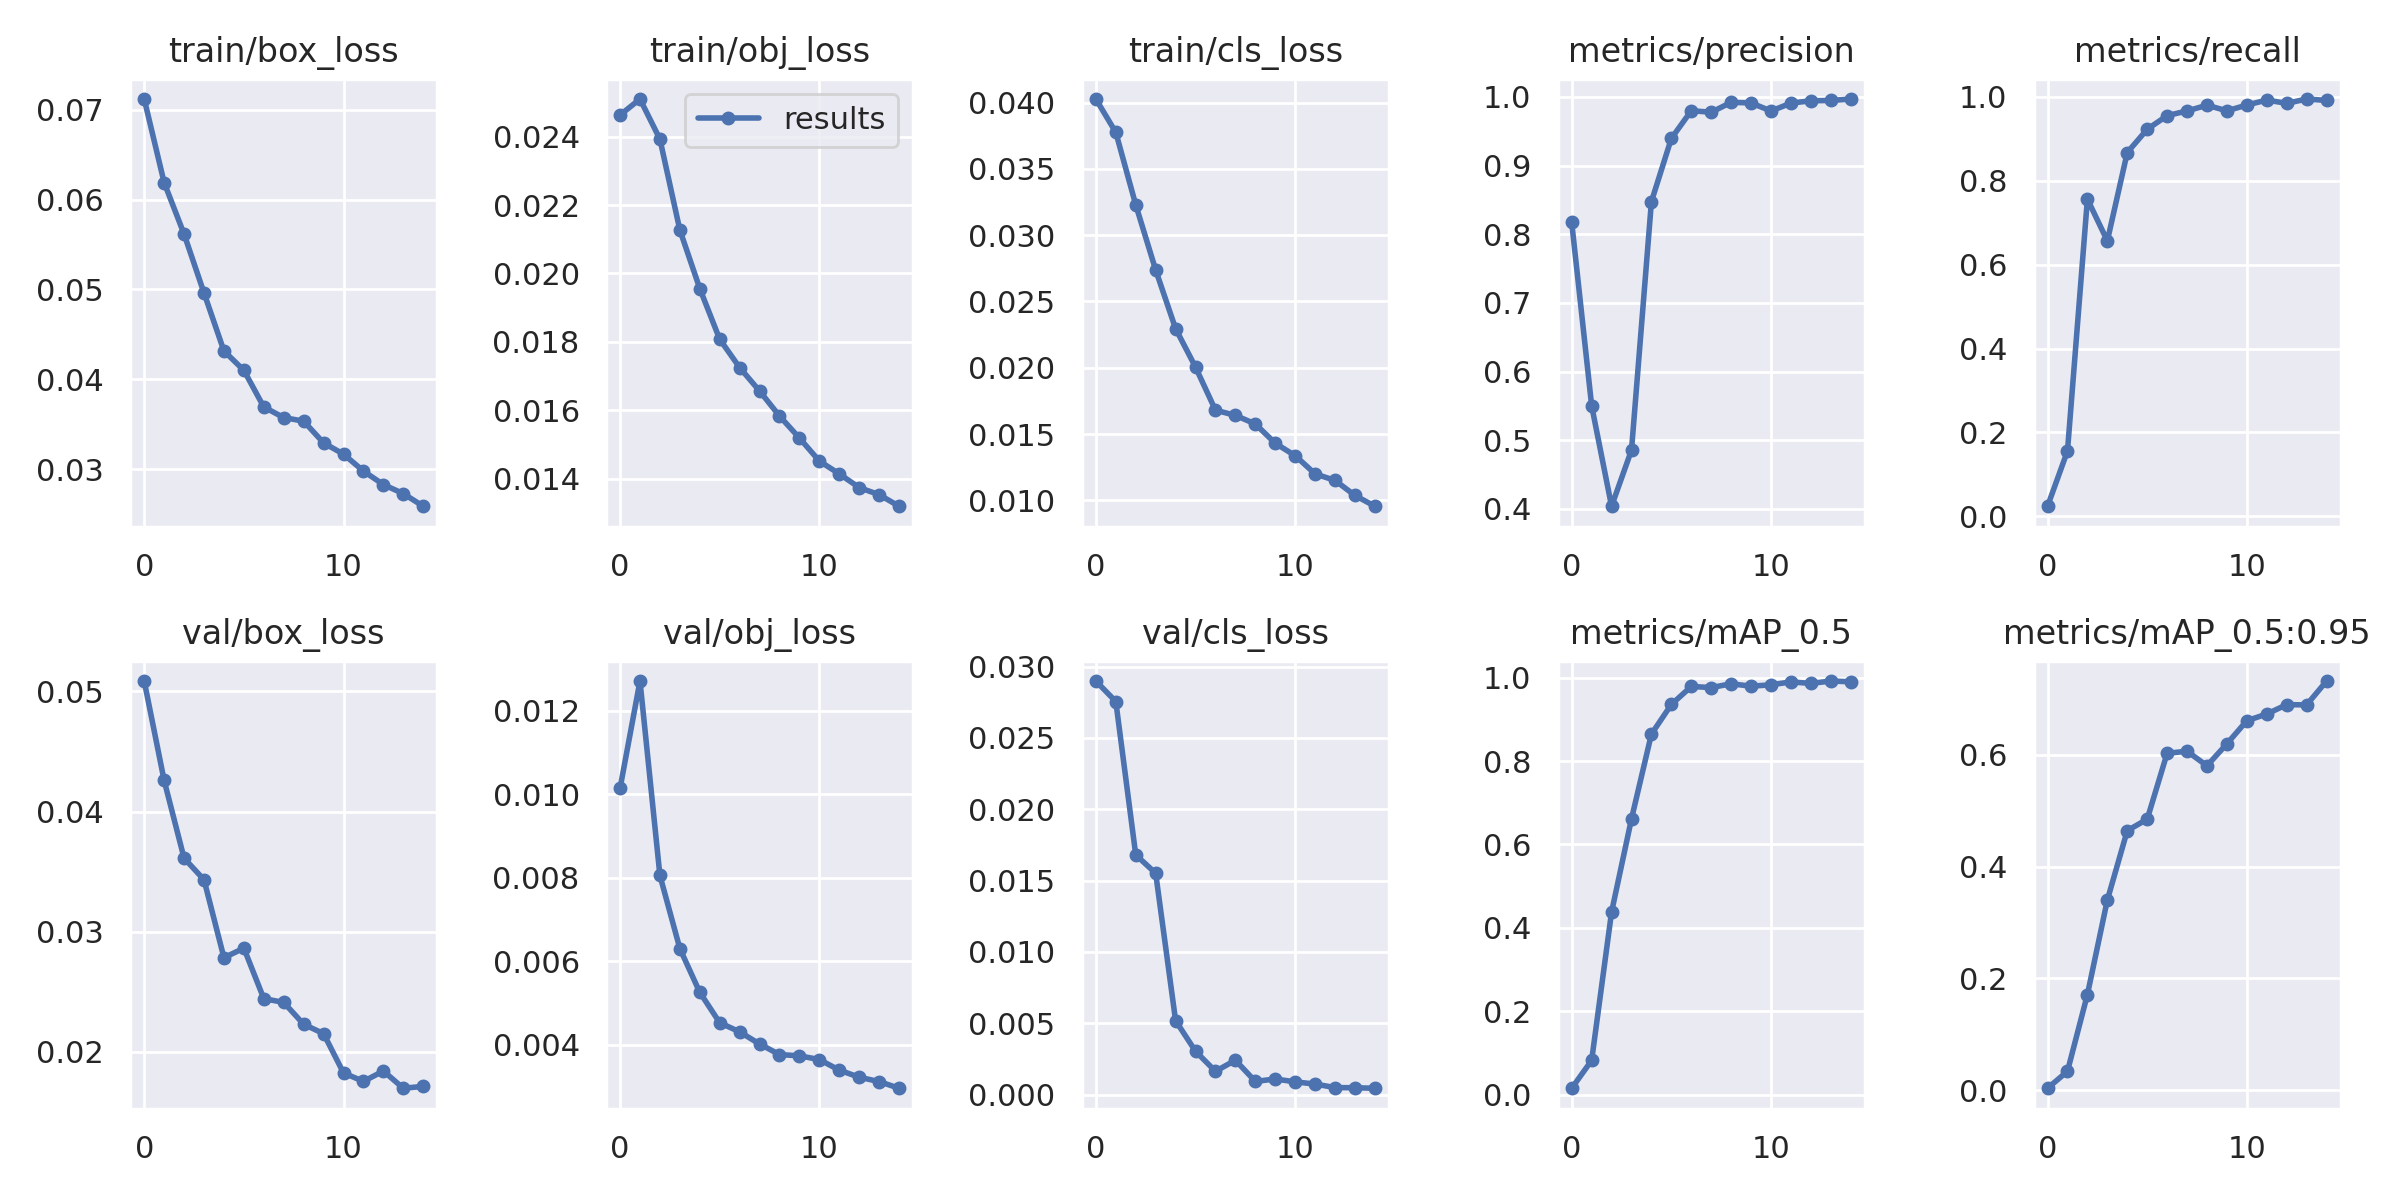

In [27]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5l_results/results.png', width=1000)  # view results.png

In [22]:
%ls runs/

train/


In [23]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [24]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.6 --source /content/yolov5/Road-Sign-Recognition-2/test/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=/content/yolov5/Road-Sign-Recognition-2/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7254609 parameters, 0 gradients, 16.8 GFLOPs
image 1/211 /content/yolov5/Road-Sign-Recognition-2/test/images/100_PNG.rf.f04a486e9c5babc63e58941396477845.jpg: 416x416 1 diverge, Done. (0.010s)
image 2/211 /content/yolov5/Road-Sign-Recognition-2/test/images/106_PNG.rf.e3f292c23c87a4feb7d02fe18b779089.jpg: 416x416 1 diverge, Done. (0.010s

In [28]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5m_results/weights/best.pt --img 416 --conf 0.6 --source /content/yolov5/Road-Sign-Recognition-2/test/images

/content/yolov5
detect: weights=['runs/train/yolov5m_results/weights/best.pt'], source=/content/yolov5/Road-Sign-Recognition-2/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20865057 parameters, 0 gradients, 47.9 GFLOPs
image 1/211 /content/yolov5/Road-Sign-Recognition-2/test/images/100_PNG.rf.f04a486e9c5babc63e58941396477845.jpg: 416x416 1 diverge, Done. (0.018s)
image 2/211 /content/yolov5/Road-Sign-Recognition-2/test/images/106_PNG.rf.e3f292c23c87a4feb7d02fe18b779089.jpg: 416x416 1 diverge, Done. (0.018s)
imag

In [29]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5n_results/weights/best.pt --img 416 --conf 0.6 --source /content/yolov5/Road-Sign-Recognition-2/test/images

/content/yolov5
detect: weights=['runs/train/yolov5n_results/weights/best.pt'], source=/content/yolov5/Road-Sign-Recognition-2/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5n summary: 213 layers, 1764577 parameters, 0 gradients, 4.1 GFLOPs
image 1/211 /content/yolov5/Road-Sign-Recognition-2/test/images/100_PNG.rf.f04a486e9c5babc63e58941396477845.jpg: 416x416 1 diverge, Done. (0.007s)
image 2/211 /content/yolov5/Road-Sign-Recognition-2/test/images/106_PNG.rf.e3f292c23c87a4feb7d02fe18b779089.jpg: 416x416 1 diverge, Done. (0.008s)
image 

In [30]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5l_results/weights/best.pt --img 416 --conf 0.6 --source /content/yolov5/Road-Sign-Recognition-2/test/images

/content/yolov5
detect: weights=['runs/train/yolov5l_results/weights/best.pt'], source=/content/yolov5/Road-Sign-Recognition-2/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5l summary: 367 layers, 46124433 parameters, 0 gradients, 107.7 GFLOPs
image 1/211 /content/yolov5/Road-Sign-Recognition-2/test/images/100_PNG.rf.f04a486e9c5babc63e58941396477845.jpg: 416x416 1 diverge, Done. (0.030s)
image 2/211 /content/yolov5/Road-Sign-Recognition-2/test/images/106_PNG.rf.e3f292c23c87a4feb7d02fe18b779089.jpg: 416x416 1 diverge, Done. (0.030s)
ima

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
%cp -r /content/yolov5/runs/train/yolov5s_results /content/gdrive/MyDrive/Computational_Intelligence/Project/Yolov5_Training
%cp -r /content/yolov5/runs/train/yolov5m_results /content/gdrive/MyDrive/Computational_Intelligence/Project/Yolov5_Training
%cp -r /content/yolov5/runs/train/yolov5n_results /content/gdrive/MyDrive/Computational_Intelligence/Project/Yolov5_Training
%cp -r /content/yolov5/runs/train/yolov5l_results /content/gdrive/MyDrive/Computational_Intelligence/Project/Yolov5_Training

In [31]:
%cp -r /content/yolov5/runs/detect/exp /content/gdrive/MyDrive/Computational_Intelligence/Project/Yolov5_Training/yolov5s_results
%cp -r /content/yolov5/runs/detect/exp2 /content/gdrive/MyDrive/Computational_Intelligence/Project/Yolov5_Training/yolov5m_results
%cp -r /content/yolov5/runs/detect/exp3 /content/gdrive/MyDrive/Computational_Intelligence/Project/Yolov5_Training/yolov5n_results
%cp -r /content/yolov5/runs/detect/exp4 /content/gdrive/MyDrive/Computational_Intelligence/Project/Yolov5_Training/yolov5l_results